In [45]:
import random
import numpy as np
import pandas as pd
import PIL

from sklearn import metrics

import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import vgg16, VGG16_Weights

import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
dataset_name = '10-monkey-species'

# A sampling rate to allow undersampling for fast execuation
sample_rate = 0.5

# Define proportion of data for test, train and validation splits.
train_split = 0.5
valid_split = 0.2
test_split = 0.3

# Desired dimensions of our images.
img_width, img_height = 128, 128

In [29]:
# Define the data transformations
train_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.RandomHorizontalFlip(p=0.5), # Flip the image horizontally.
    transforms.RandomVerticalFlip(p=0.5), # Flip the image vertically.
    transforms.RandomRotation(degrees=20), # Rotate the image by angle.
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), # Change the brightness, contrast and saturation of an image.
    transforms.ToTensor()
])

In [30]:
test_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor()
])

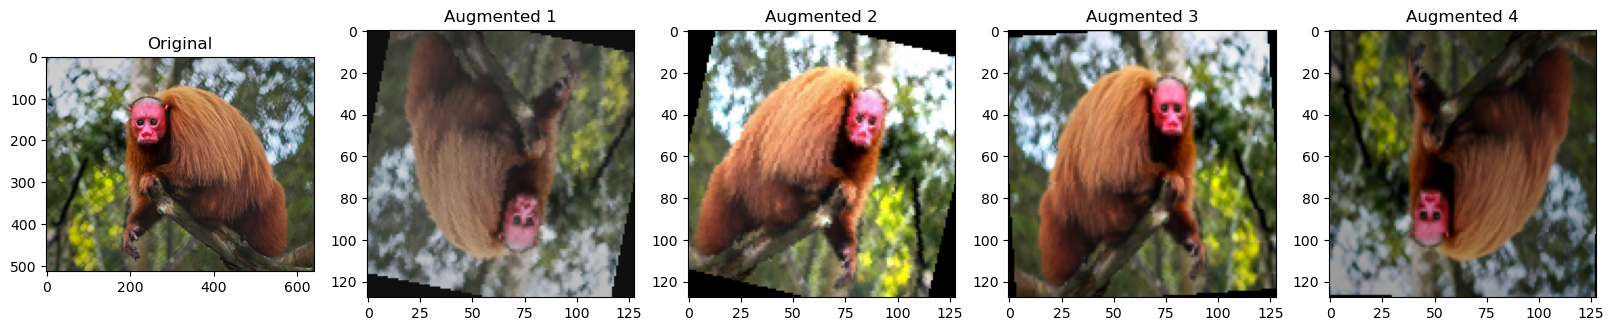

In [31]:
# Load the original image
img_path = "../Data/" + dataset_name + '/bald_uakari/n200.jpg'
img4plot = PIL.Image.open(img_path)

# Apply the transformations to the original image
augmented_images = [train_transforms(img4plot) for _ in range(4)]

# Plot the original image and the augmented images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
axes[0].imshow(img4plot)
axes[0].set_title('Original')

for i, aug_img in enumerate(augmented_images):
    axes[i+1].imshow(aug_img.permute(1, 2, 0))
    axes[i+1].set_title(f'Augmented {i+1}')

plt.show()

In [32]:
# Load the data
dataset = datasets.ImageFolder("../Data/" + dataset_name + "/", transform = None)

# Split the data into train, validation and test sets
test_size = int(test_split * len(dataset))
train_val_size = int(0.7 * len(dataset))
train_val_size = len(dataset) - test_size
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

train_size = int((train_split/(train_split + valid_split)) * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

In [33]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x, y

In [34]:
train_dataset = CustomDataset(train_dataset, transform=train_transforms)
val_dataset = CustomDataset(val_dataset, transform=test_transforms)
test_dataset = CustomDataset(test_dataset, transform=test_transforms)

In [35]:
batch_size = 32  # Batch size used during training

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [36]:
items = iter(train_loader)
image, label = next(items)

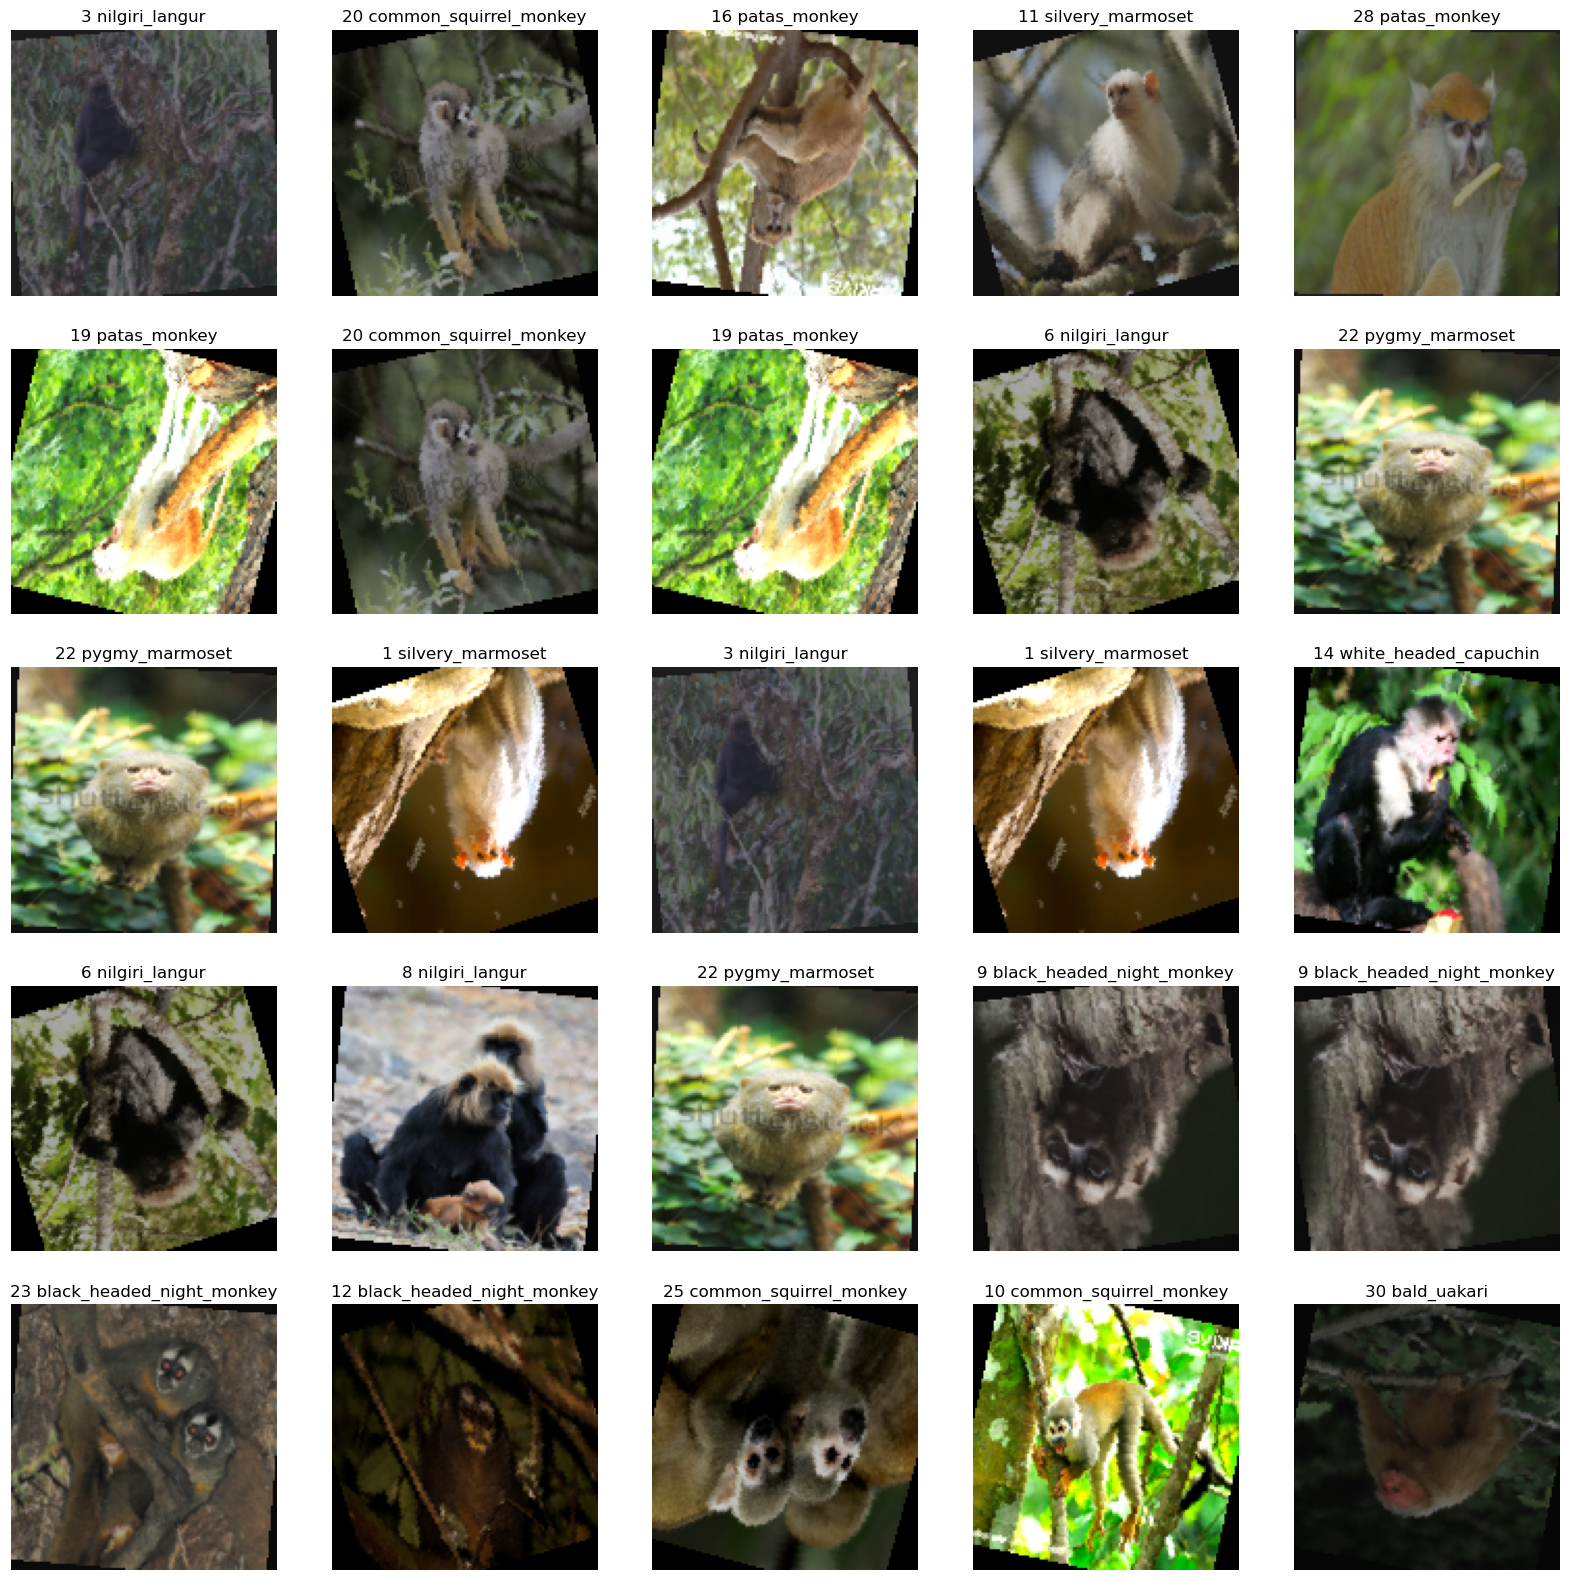

In [37]:
pltsize=4
row_images = 5
col_images = 5
label_names = dataset.classes
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

np_image = image.numpy()
np_label = label.numpy()
for i in range(row_images * col_images):
    i_rand = random.randint(0, len(image) - 1)
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(np_image[i_rand], (1, 2, 0)))
    plt.title((str(i_rand) + " " + label_names[np_label[i_rand]]))

plt.show()

In [38]:
dataset.class_to_idx

{'bald_uakari': 0,
 'black_headed_night_monkey': 1,
 'common_squirrel_monkey': 2,
 'japanese_macaque': 3,
 'mantled_howler': 4,
 'nilgiri_langur': 5,
 'patas_monkey': 6,
 'pygmy_marmoset': 7,
 'silvery_marmoset': 8,
 'white_headed_capuchin': 9}

In [39]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5),
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(in_features=64 * 4 * 4, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=128, out_features=num_classes)
        )

    def forward(self, x):
        return self.layers(x)

In [40]:
model = CNN(num_classes = len(dataset.class_to_idx))
print(model)

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stri

In [41]:
epochs = 10

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define lists to store the training and validation loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()

    # Initialize the training loss and accuracy for this epoch
    running_train_loss = 0.0
    running_train_corrects = 0

    running_val_loss = 0.0
    running_val_corrects = 0

    for i, (X_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Compute statistics
        running_train_loss += loss.item() * batch_size
        running_train_corrects += torch.sum(torch.argmax(outputs, dim=1) == y_train)

    # Compute statistics for the entire epoch
    epoch_train_loss = running_train_loss / train_size
    epoch_train_acc = running_train_corrects.item() / train_size * 100

    # Append the training statistics to the lists
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Evaluation on validation set
    with torch.no_grad():
        for i, (X_val, y_val) in enumerate(val_loader):
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_corrects = torch.sum(torch.argmax(val_outputs, dim=1) == y_val)

            # Compute statistics
            running_val_loss += val_loss.item() * batch_size
            running_val_corrects += torch.sum(torch.argmax(val_outputs, dim=1) == y_val)


    # Compute statistics for the entire epoch
    epoch_val_loss = running_val_loss / val_size
    epoch_val_acc = running_val_corrects.item() / val_size * 100

    # Append the validation statistics to the lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_acc:.2f}%, \
          Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.2f}%')

Epoch 1/10, Training Loss: 2.4248, Training Accuracy: 12.93%,           Validation Loss: 2.3835, Validation Accuracy: 21.01%
Epoch 2/10, Training Loss: 2.2385, Training Accuracy: 19.63%,           Validation Loss: 2.2987, Validation Accuracy: 25.29%
Epoch 3/10, Training Loss: 2.1244, Training Accuracy: 24.61%,           Validation Loss: 2.1708, Validation Accuracy: 29.96%
Epoch 4/10, Training Loss: 1.9831, Training Accuracy: 30.53%,           Validation Loss: 2.0556, Validation Accuracy: 37.35%
Epoch 5/10, Training Loss: 1.9108, Training Accuracy: 31.15%,           Validation Loss: 1.9740, Validation Accuracy: 33.07%
Epoch 6/10, Training Loss: 1.8312, Training Accuracy: 36.92%,           Validation Loss: 1.9199, Validation Accuracy: 38.13%
Epoch 7/10, Training Loss: 1.8226, Training Accuracy: 35.83%,           Validation Loss: 1.9135, Validation Accuracy: 38.91%
Epoch 8/10, Training Loss: 1.7926, Training Accuracy: 37.38%,           Validation Loss: 2.0134, Validation Accuracy: 37.35%


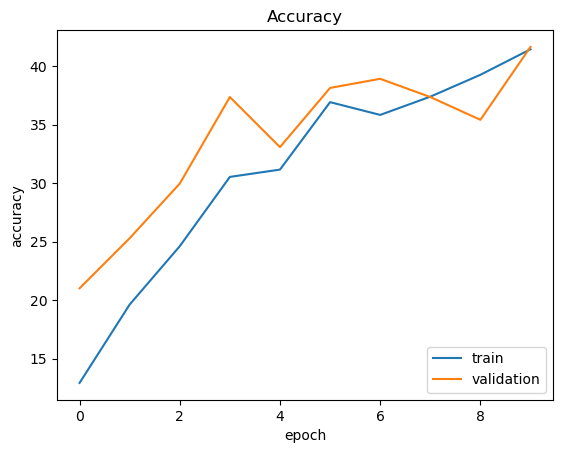

In [42]:
# Summarize history for accuracy
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

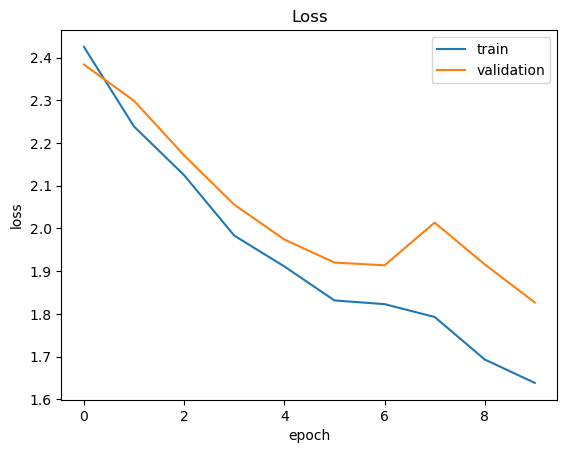

In [43]:
# Summarize history for loss
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [44]:
X_test_cat = []
y_true = []
y_pred = []

for i, (X_test, y_test) in enumerate(test_loader):
    test_outputs = model(X_test)
    _, preds = torch.max(test_outputs, 1)

    # Add up the predictions
    X_test_cat.extend(X_test)
    y_true.extend(y_test)
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
# Print performance details
print(metrics.classification_report(y_true, y_pred))

# Print confusion matrix
print("Confusion Matrix")
display(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       0.62      0.78      0.69        40
           1       0.35      0.36      0.35        39
           2       0.41      0.42      0.41        43
           3       0.60      0.58      0.59        48
           4       0.40      0.79      0.54        43
           5       0.20      0.08      0.12        37
           6       0.57      0.42      0.49        40
           7       0.67      0.07      0.12        29
           8       0.47      0.55      0.51        38
           9       0.22      0.21      0.22        28

    accuracy                           0.45       385
   macro avg       0.45      0.43      0.40       385
weighted avg       0.46      0.45      0.42       385

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,31,3,0,3,0,0,1,0,2,0,40
1,4,14,6,2,2,1,1,0,2,7,39
2,1,5,18,1,2,2,2,0,6,6,43
3,6,3,1,28,3,0,2,0,5,0,48
4,1,1,0,0,34,4,0,0,0,3,43
5,0,1,4,1,26,3,0,0,0,2,37
6,3,2,5,5,2,0,17,0,4,2,40
7,1,9,8,2,2,2,1,2,2,0,29
8,3,2,1,3,1,1,5,0,21,1,38


In [46]:
model = vgg16(weights=VGG16_Weights.DEFAULT)

In [47]:
for param in model.parameters():
    param.requires_grad = False

In [48]:
input_size = model.classifier[0].in_features

In [49]:
num_classes = len(dataset.classes)
model.classifier = nn.Sequential(
    nn.Linear(input_size, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

In [50]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [51]:
epochs = 10

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define lists to store the training and validation loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()

    # Initialize the training loss and accuracy for this epoch
    running_train_loss = 0.0
    running_train_corrects = 0

    running_val_loss = 0.0
    running_val_corrects = 0

    for i, (X_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Compute statistics
        running_train_loss += loss.item() * batch_size
        running_train_corrects += torch.sum(torch.argmax(outputs, dim=1) == y_train)

    # Compute statistics for the entire epoch
    epoch_train_loss = running_train_loss / train_size
    epoch_train_acc = running_train_corrects.item() / train_size * 100

    # Append the training statistics to the lists
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Evaluation on validation set
    with torch.no_grad():
        for i, (X_val, y_val) in enumerate(val_loader):
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_corrects = torch.sum(torch.argmax(val_outputs, dim=1) == y_val)

            # Compute statistics
            running_val_loss += val_loss.item() * batch_size
            running_val_corrects += torch.sum(torch.argmax(val_outputs, dim=1) == y_val)


    # Compute statistics for the entire epoch
    epoch_val_loss = running_val_loss / val_size
    epoch_val_acc = running_val_corrects.item() / val_size * 100

    # Append the validation statistics to the lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_acc:.2f}%, \
          Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.2f}%')

Epoch 1/10, Training Loss: 5.3671, Training Accuracy: 24.77%,           Validation Loss: 2.4376, Validation Accuracy: 44.36%
Epoch 2/10, Training Loss: 1.5601, Training Accuracy: 49.69%,           Validation Loss: 1.6049, Validation Accuracy: 60.70%
Epoch 3/10, Training Loss: 1.3947, Training Accuracy: 56.23%,           Validation Loss: 2.7778, Validation Accuracy: 58.37%
Epoch 4/10, Training Loss: 1.4073, Training Accuracy: 58.72%,           Validation Loss: 1.6566, Validation Accuracy: 64.98%
Epoch 5/10, Training Loss: 1.2478, Training Accuracy: 61.53%,           Validation Loss: 1.9972, Validation Accuracy: 67.32%
Epoch 6/10, Training Loss: 1.1645, Training Accuracy: 64.64%,           Validation Loss: 2.5277, Validation Accuracy: 66.93%
Epoch 7/10, Training Loss: 1.0200, Training Accuracy: 65.73%,           Validation Loss: 2.9139, Validation Accuracy: 68.87%
Epoch 8/10, Training Loss: 1.1293, Training Accuracy: 66.98%,           Validation Loss: 2.9524, Validation Accuracy: 68.48%


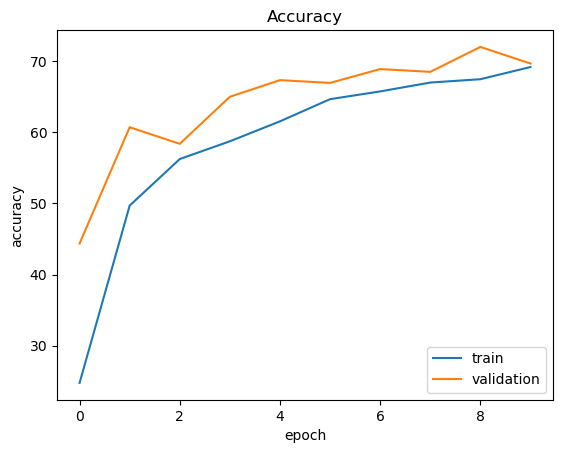

In [52]:
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

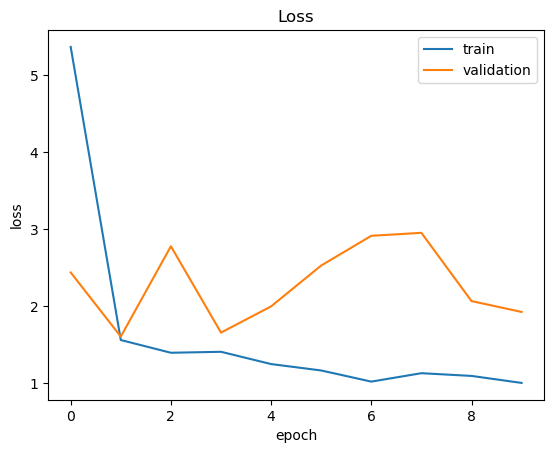

In [53]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [54]:
X_test_cat = []
y_true = []
y_pred = []
for i, (X_test, y_test) in enumerate(test_loader):
    test_outputs = model(X_test)
    _, preds = torch.max(test_outputs, 1)

    # Add up the predictions
    X_test_cat.extend(X_test)
    y_true.extend(y_test)
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
# Print performance details
print(metrics.classification_report(y_true, y_pred))

# Print confusion matrix
print("Confusion Matrix")
display(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       0.80      0.70      0.75        40
           1       0.74      0.82      0.78        39
           2       0.69      0.63      0.66        43
           3       0.55      0.79      0.65        48
           4       0.68      0.91      0.78        43
           5       0.84      0.43      0.57        37
           6       0.83      0.75      0.79        40
           7       0.69      0.62      0.65        29
           8       0.75      0.63      0.69        38
           9       0.48      0.50      0.49        28

    accuracy                           0.69       385
   macro avg       0.71      0.68      0.68       385
weighted avg       0.71      0.69      0.69       385

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,28,0,2,8,1,0,0,0,0,1,40
1,0,32,1,1,3,0,1,1,0,0,39
2,0,5,27,1,3,0,2,1,0,4,43
3,2,2,0,38,0,1,1,2,2,0,48
4,0,1,0,1,39,1,0,1,0,0,43
5,0,1,1,1,9,16,0,1,0,8,37
6,0,1,3,4,0,0,30,0,2,0,40
7,1,0,2,5,0,1,0,18,2,0,29
8,2,0,2,6,0,0,2,0,24,2,38
